# Machine Learning Fall 99 <img src = 'https://ece.ut.ac.ir/cict-theme/images/footer-logo.png' alt="Tehran-University-Logo" width="150" height="150" align="right">
## HO1 Task
### By Omid Vaheb

In this hands-on we try to build a polynomial model in order to estimate one of features of dataset with other features.

At first we import necessary libraries.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# sklearn stuff
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Explain Data:

Affinity
Spending data from <a src='https://www.affinity.solutions/'> affinity solutions </a>.

* spend_all: Seasonally adjusted credit/debit card spending in all merchant category codes (MCC)

* spend_acf: Seasonally adjusted credit/debit card spending in accomodation and food service (ACF)

* spend_aer: Seasonally adjusted credit/debit card spending in arts, entertainment, and recreation (AER)

* spend_apg: Seasonally adjusted credit/debit card spending in general merchandise stores (GEN)

* spend_grf: Seasonally adjusted credit/debit card spending in grocery and food store (GRF)

* spend_hcs: Seasonally adjusted credit/debit card spending in health care and social assistance (HCS)

* spend_tws: Seasonally adjusted credit/debit card spending in transportation and warehousing (TWS)

## Load Data:

The next step is to load dataset and removing spend_all column because it is sum of other columns and is not an independent feature so it is not a permissible feature for regression.

In [2]:
PATH_TO_DATA = 'Affinity-City-Daily-final.csv'
Data = pd.read_csv(PATH_TO_DATA)

In [4]:
Data = Data.drop(['spend_all'], axis=1)

In [5]:
Data

,year,month,day,cityid,spend_acf,spend_aer,spend_grf,spend_hcs,spend_tws
0,2020,1,13,1,-0.00322,0.00706,0.00389,-0.03550,-0.00510
1,2020,1,13,2,0.00660,-0.07790,-0.00956,0.06040,-0.03250
2,2020,1,13,3,-0.10400,0.03340,0.01240,-0.00547,0.01810
3,2020,1,13,4,-0.03560,-0.15000,0.00405,0.03050,-0.01790
4,2020,1,13,5,-0.00770,-0.04040,0.00888,-0.00653,0.00175
...,...,...,...,...,...,...,...,...,...
12245,2020,9,13,49,-0.32600,-0.42000,-0.09140,-0.03690,-0.57100
12246,2020,9,13,50,-0.19800,-0.68700,0.37900,-0.35200,-0.55500
12247,2020,9,13,51,-0.00545,-0.29800,0.21200,0.61400,-0.32400
12248,2020,9,13,52,-0.42000,-0.73100,0.16200,-0.35200,-0.56800


I chose last column, spend_tws, to estimate with other features.

In [11]:
X = Data[Data.columns[4:8]]
y = Data[Data.columns[8]]

In [12]:
X

,spend_acf,spend_aer,spend_grf,spend_hcs
0,-0.00322,0.00706,0.00389,-0.03550
1,0.00660,-0.07790,-0.00956,0.06040
2,-0.10400,0.03340,0.01240,-0.00547
3,-0.03560,-0.15000,0.00405,0.03050
4,-0.00770,-0.04040,0.00888,-0.00653
...,...,...,...,...
12245,-0.32600,-0.42000,-0.09140,-0.03690
12246,-0.19800,-0.68700,0.37900,-0.35200
12247,-0.00545,-0.29800,0.21200,0.61400
12248,-0.42000,-0.73100,0.16200,-0.35200


In [13]:
y

0       -0.00510
1       -0.03250
2        0.01810
3       -0.01790
4        0.00175
          ...   
12245   -0.57100
12246   -0.55500
12247   -0.32400
12248   -0.56800
12249   -0.39000
Name: spend_tws, Length: 12250, dtype: float64

## Split Data into Train and Test:

Now we split dataset into train and test with 50% for each group.

In [14]:
def split(X, y, train_size=0.5):
    mid = int(len(y)*train_size)
    X_train = X[:mid]
    X_test  = X[mid:]
    y_train = y[:mid]
    y_test  = y[mid:]
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = split(X, y)

In [16]:
X_train.shape , X_test.shape

((6125, 4), (6125, 4))

In [17]:
y_train.shape, y_test.shape

((6125,), (6125,))

## Train Regression Models:

Now we fit first degree polynomial regressior to our train data and estimate values for test data and visualize both estimated and actual values in a plot..

In [18]:
def vis(y, y_pred):
    temp = [i for i in range(len(y))]
    plt.plot(temp, y_pred, color = 'blue', label='$Estimated Value$')
    plt.plot(temp, y, color= 'green', label='$True Value$')
    plt.grid()
    plt.legend()
    plt.title('Measured and estimated values')
    plt.xlabel('Time')
    plt.ylabel('Value')

In [19]:
p_reg = Pipeline([
        ("std_scaler", StandardScaler()),
        ("poly_features", PolynomialFeatures(degree=1, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

In [20]:
p_reg.fit(X_train, y_train)
y_train_pred = p_reg.predict(X_train)
mean_squared_error(y_train, y_train_pred)

0.006645750099123938

In [21]:
y_test_pred = p_reg.predict(X_test)
mean_squared_error(y_test, y_test_pred)

0.012887329819480323

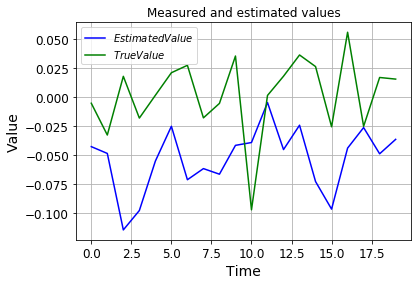

In [22]:
vis(y_train[0:20], y_train_pred[0:20]) 

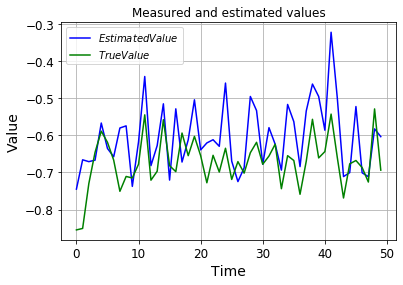

In [23]:
vis(y_test[200:250], y_test_pred[200:250]) 

## Finding the appropriate degree for our polynomial regressior:

The next step is to find the best polynomial degree for our model so we try degrees 1 to 6 and degree 3 is the best one because it has lowest MSE loss for test data.

In [24]:
test_mses = []
train_mses = []
degrees = [i for i in range(1, 6)]
for d in degrees:
    p_reg= Pipeline([
            ("std_scaler", StandardScaler()),
            ("poly_features", PolynomialFeatures(degree=d, include_bias=False)),
            ("lin_reg", LinearRegression()),
        ])
    p_reg.fit(X_train, y_train)
    y_train_pred = p_reg.predict(X_train)
    train_mses.append(mean_squared_error(y_train, y_train_pred))
    y_test_pred = p_reg.predict(X_test)
    test_mses.append(mean_squared_error(y_test, y_test_pred))

Text(0.5, 0, 'degree')

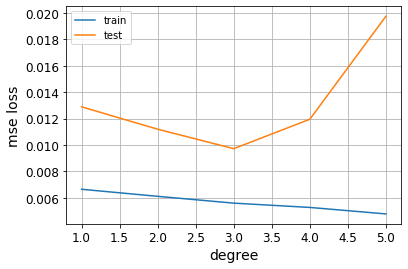

In [25]:
plt.plot(degrees, train_mses, label='train')
plt.plot(degrees, test_mses, label='test')
plt.grid()
plt.legend()
plt.ylabel('mse loss')
plt.xlabel('degree')

## Use the Best Model:

The final step is to estimte values with our third degree polynomia

In [26]:
p_reg= Pipeline([
            ("std_scaler", StandardScaler()),
            ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
            ("lin_reg", LinearRegression()),
        ])
p_reg.fit(X_train, y_train)
y_train_pred = p_reg.predict(X_train)
y_test_pred = p_reg.predict(X_test)
mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)

(0.005595414421579764, 0.009718986150753926)

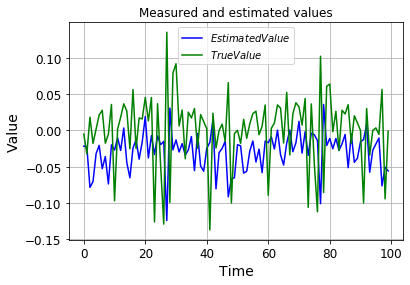

In [27]:
vis(y_train[0:100], y_train_pred[0:100]) 

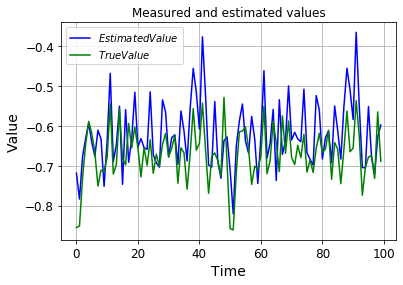

In [28]:
vis(y_test[200:300], y_test_pred[200:300]) 